### Load required libraries

In [1]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

SEED = 42

Using TensorFlow backend.


### Load and reshape data

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()
reshaped_trainX = trainX.reshape([trainX.shape[0], -1]).astype('float32')
reshaped_testX = testX.reshape([testX.shape[0], -1]).astype('float32')

print('Train dataset shape:\t%s\nTrain dataset reshaped:\t%s\nLabels dataset shape:\t%s' % (trainX.shape, reshaped_trainX.shape, trainy.shape))
print('\nTrain dataset shape:\t%s\nTrain dataset reshaped:\t%s\nLabels dataset shape:\t%s' % (testX.shape, reshaped_testX.shape, testy.shape))

11493376/11490434 [==============================] - 0s 0us/step
Train dataset shape:	(60000, 28, 28)
Train dataset reshaped:	(60000, 784)
Labels dataset shape:	(60000,)

Train dataset shape:	(10000, 28, 28)
Train dataset reshaped:	(10000, 784)
Labels dataset shape:	(10000,)


### Explore content

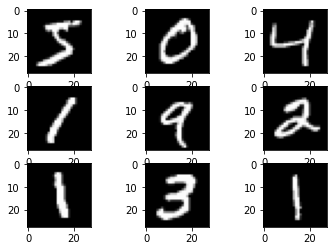

In [3]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()

### Build a simple Random Forest classifier

In [4]:
rf = RandomForestClassifier(random_state = SEED, n_jobs=-1)

start = time.time()
rf.fit(reshaped_trainX, trainy)

predicted = rf.predict(reshaped_testX)
elapsed_time = time.time() - start

print("Model training took %.0f seconds for standard parameters.\nAccuracy reached: %.4f" % (elapsed_time, accuracy_score(testy, predicted)))

Model training took 22 seconds for standard parameters.
Accuracy reached: 0.9705


In [5]:
print ("Classification Report:\n")
print(classification_report(testy, predicted))
print ("\nConfusion Report:\n")
print(confusion_matrix(testy, predicted))

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion Report:

[[ 971    0    0    0    0    2    3    1    3    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [   6    0 1002    5    3    0    3    8    5    0]
 [   1    0    9  972    0    9    0  

### Optimize Random Forest classifier parameters

In [6]:
space = {'max_depth': hp.quniform('max_depth', 1, 100, 1),
         'max_features': hp.quniform('max_features', 1, 50, 1),
         'n_estimators': hp.quniform('n_estimators', 25, 500, 5),
         'criterion': hp.choice('criterion', ["gini", "entropy"])}

In [7]:
def rf_tuning(space):
    
    global best_score, best_rf_model
    
    clf = RandomForestClassifier(max_depth = int(space['max_depth']),
                                 max_features = int(space['max_features']),
                                 n_estimators = int(space['n_estimators']), 
                                 criterion = space['criterion'], n_jobs=-1, random_state = SEED)
    
    clf.fit(reshaped_trainX, trainy)

    pred = clf.predict(reshaped_testX)
    accuracy = 1-accuracy_score(testy, predicted)
    
    if (accuracy < best_score):
        best_score = accuracy
        best_rf_model = clf
    
    return {'loss': accuracy, 'status': STATUS_OK }

In [8]:
trials = Trials()
start = time.time()
neval = 50
best_score = 1.0
best_rf_model = []

best = fmin(fn = rf_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = neval,
            trials = trials,
            rstate = np.random.RandomState(SEED))

elapsed_time = time.time() - start

100%|██████████| 50/50 [53:14<00:00, 63.89s/trial, best loss: 0.02949999999999997]


In [9]:
print("Parameters optimization took %.0f seconds for %d candidates.\nAccuracy reached: %.4f\n\nOptimal parameters found:\n%s" % (elapsed_time, neval, (1-best_score), best))

Parameters optimization took 3194 seconds for 50 candidates.
Accuracy reached: 0.9705

Optimal parameters found:
{'criterion': 1, 'max_depth': 8.0, 'max_features': 42.0, 'n_estimators': 240.0}


In [10]:
predicted = best_rf_model.predict(reshaped_testX)

In [11]:
print ("Classification Report:\n")
print(classification_report(testy, predicted))
print ("\nConfusion Report:\n")
print(confusion_matrix(testy, predicted))

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.94      0.92      0.93      1010
           4       0.93      0.90      0.91       982
           5       0.95      0.89      0.92       892
           6       0.94      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.92      0.92      0.92       974
           9       0.86      0.92      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


Confusion Report:

[[ 968    1    1    0    0    1    4    1    3    1]
 [   0 1118    2    4    0    2    3    1    5    0]
 [   8    1  955    9   14    3   11   19    9    3]
 [   3    0   22  926    2   20    2  